# Classificació d'imatges amb CNN

En aquest notebook, es mostra com classificar imatges amb una xarxa neuronal convolucional (CNN). Veurem també quin seria el rendiment d'una xarxa neuronal feedforward (FNN) en aquest mateix problema.

## Instal·lació de l'entorn

En primer lloc, instal·lem les llibreries necessàries per a executar el codi. En el nostre cas, necessitarem `keras`.

In [11]:
%pip install keras_cv keras tensorflow opencv-python-headless

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.8/870.8 kB 11.0 MB/s eta 0:00:00
  Created wheel for grpclib: filename=grpclib-0.4.7-py3-none-any.whl size=76229 sha256=4a4df74f7393e0f237a0c8041a1c7c6fa17bc417637b60d25d21e14dc36c3e7f
  Stored in directory: /home/carles/.cache/pip/wheels/1a/6e/f8/47a179a8cf84417e94206ee7bdee3cc4219a011e6ca1973eb0
Successfully built grpclib

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated pa

Ara importarem les llibreries necessàries per a fer classificació d'imatges utilitzant xarxes neuronals feed forward.

In [12]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers.experimental.preprocessing import Rescaling

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

2025-02-05 23:55:21.275322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 23:55:21.340059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-05 23:55:21.340090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-05 23:55:21.342198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 23:55:21.347548: I tensorflow/core/platform/cpu_feature_guar

Utilitzarem keras per a construir la xarxa neuronal (de fons utilitza tensorflow) i per a carregar el conjunt de dades.

## Preparem les dades

Com ja sabem, el rendiment de les xarxes neuronals _Feed Forward_ (FNN) en tasques de classificació d'imatges no és gaire bo. Això és degut a que les xarxes FNN no són capaces de capturar les relacions espacials entre els píxels de la imatge. Així i tot, començarem amb una xarxa FNN per a veure quin és el rendiment que podem obtenir.

Com a _DataSet_, utilitzarem el conjunt de dades `cats_vs_dogs` que obtindrem a continuació. Aquest conjunt de dades conté 25.000 imatges en color de 224x224 píxels, amb 2 classes diferents: 'Cat' i 'Dog'.

Son petites, però suficients per a mostrar com funcionen les xarxes neuronals en tasques de classificació d'imatges.

Comencem carregant descarregantv el zip en el datatset i descomprimint-lo.

In [13]:
import os, zipfile
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !wget -P data https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

--2025-02-05 23:55:23--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolviendo download.microsoft.com (download.microsoft.com)... 2a02:26f0:e0:295::317f, 2a02:26f0:e0:290::317f, 2.17.152.210
Conectando con download.microsoft.com (download.microsoft.com)[2a02:26f0:e0:295::317f]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 824887076 (787M) [application/octet-stream]
Grabando a: «data/kagglecatsanddogs_5340.zip»

kagglecatsanddogs_5 100%[===================>] 786,67M  23,8MB/s    en 35s     

2025-02-05 23:55:58 (22,3 MB/s) - «data/kagglecatsanddogs_5340.zip» guardado [824887076/824887076]



En següent lloc haurem de verificar que les dades estiguen en el format correcte per poder ser evaluades, ja que moltes vegades les dades ens arriben corruptes o en problemes de compressió.

In [14]:
import glob

def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        return im.format=='JPEG'
    except Exception as e:
        print(e)
        return False

def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image or wrong format: {}".format(fn))
            os.remove(fn)

check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image or wrong format: data/PetImages/Cat/10073.jpg
Corrupt image or wrong format: data/PetImages/Cat/10125.jpg
Corrupt image or wrong format: data/PetImages/Cat/10404.jpg
Corrupt image or wrong format: data/PetImages/Cat/10501.jpg
Corrupt image or wrong format: data/PetImages/Cat/10820.jpg
Corrupt image or wrong format: data/PetImages/Cat/10874.jpg
Corrupt image or wrong format: data/PetImages/Cat/11083.jpg
Corrupt image or wrong format: data/PetImages/Cat/11086.jpg
Corrupt image or wrong format: data/PetImages/Cat/11095.jpg
Corrupt image or wrong format: data/PetImages/Cat/11210.jpg
Corrupt image or wrong format: data/PetImages/Cat/11397.jpg
Corrupt image or wrong format: data/PetImages/Cat/1151.jpg
Corrupt image or wrong format: data/PetImages/Cat/11565.jpg
Corrupt image or wrong format: data/PetImages/Cat/11729.jpg
Corrupt image or wrong format: data/PetImages/Cat/11864.jpg
Corrupt image or wrong format: data/PetImages/Cat/11874.jpg
Corrupt image or wrong format: data/PetIm

/home/carles/Documentos/notebooks/.venv/lib64/python3.11/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Ara haurem de crear un Dataset amb les dades obteses del Zip. Com estem utilitzant Keras ens aprofitarem de la funció `image_dataset_from_directory` que ens permet crear un `Lazy Dataset` automàticament.

Aquest `Lazy Dataset` ens permetrà carregar les imatges poc a poc; sense sobrecarregar la memòria. També anirà etiquetat auntomàticament, amb el nom de les carpetes contenedores.


In [15]:
data_dir = 'data/PetImages'
batch_size = 64
ds_train = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)

ds_test = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)


Found 24769 files belonging to 2 classes.
Using 19816 files for training.
Found 24769 files belonging to 2 classes.
Using 4953 files for validation.


Vejam que les classes s'ha aplicat i algunes de les imatges.

In [16]:
class_names = ds_train.class_names
print(class_names)

['Cat', 'Dog']


In [17]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


ImportError: cannot import name 'LoadFlags' from 'matplotlib.ft2font' (/home/carles/Documentos/notebooks/.venv/lib64/python3.11/site-packages/matplotlib/ft2font.cpython-311-x86_64-linux-gnu.so)

## Xarxes neuronals feed forward

### Creem el model

Ara crearem el model de xarxa neuronal. Començarem amb una xarxa feed forward. Aquesta xarxa tindrà una capa d'entrada, dues capes ocultes i una capa de sortida.

La capa d'entrada tindrà 224x224x3 = 50176 neurones, ja que les imatges tenen 224x224 píxels i tres canals de color (RGB).

Per triar les dimensions de les capes ocultes, hem de tenir en compte que les imatges són petites i que volem que el model sigui lleuger. Així i tot, volem que el model sigui prou gran com per a capturar les relacions espacials entre els píxels de les imatges. Per això, triarem dues capes ocultes amb 1024 i 512 neurones, respectivament.

La capa de sortida tindrà 1 neurones, ja que hi ha 1 classe diferents. Utilitzarem la funció d'activació `sigmoide` per a obtenir les probabilitats de pertànyer a cada classe.

In [18]:
model = Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)), # Normalitzem les dades. El valor de cada color en cada pixel quedarà entre 0 i 1
    Flatten(), # Utilitzem la capa Flatten per convertir les imatges en vectors
    Dense(1024, activation='relu'), # Capa oculta amb 1024 neurones i funció d'activació relu.
    Dense(512, activation='relu'), # Capa oculta amb 512 neurones i funció d'activació relu.
    Dense(1, activation='sigmoid') # Capa de sortida amb 1 neurona i funció d'activació sigmoide.
])

### Entrenem el model

Ara entrenarem el model. Per a fer-ho, primer hem de compilar-lo. Utilitzarem l'optimitzador `adam` i la funció de pèrdua `binary_crossentropy`. A més, monitoritzarem l'exactitud del model durant l'entrenament.

Un cop compilat el model, l'entrenarem durant 10 èpoques. Utilitzarem un lot de 128 imatges (batch size).

In [19]:
# Compilació del model. Utilitzem l'optimitzador Adam, la funció de pèrdua binary_crossentropy i la mètrica accuracy.

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Entrenament del model. Utilitzem 10 èpoques i un lot de 128 mostres.
history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=(ds_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 1024)              154141696 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 154667009 (590.01 MB)
Trainable params: 154667009 (590.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 29/310 [=>............................] - ETA: 5:14 - loss: 55.8770 - accuracy: 0.5027

KeyboardInterrupt: 

Com podem veure, no hem aconsseguit gran cosa, ja que el `val_accuracy` apenes passa del 50% (tenient dues classes és equivalent al que tindriem triant a cegues).

Graficarem les dades de l'entrenament per veure-ho més clar.

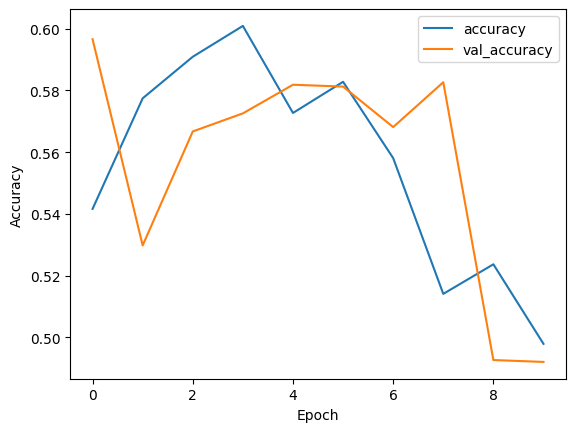

In [10]:
# Mostrem la pèrdua i l'accuracy del model durant l'entrenament.

def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()

plot_history(history)

Podem veure com, en cap moment hem pogut començar a millorar en les nostres prediccions.

Les xarxes neuronals feed forward no són capaces de capturar les relacions espacials entre els píxels de les imatges. Això fa que siguin molt fàcils de sobreajustar, com hem vist. HAurem de provar amb una xarxa neuronal convolucional (CNN) per a veure si podem millorar el rendiment.

## Xarxes neuronals convolucionals (CNN)

De cara a la pràctica, la diferència més gran en la construcció de la xarxa neuronal és que afegirem capes convolucionals i de _pooling_.

Les capes convolucionals són capaces de capturar les relacions espacials entre els píxels de la imatge. Això és el que fa que les CNN siguin molt més eficients que les FNN en tasques de classificació d'imatges.

Les capes de _pooling_ són capaces de reduir la mida de les imatges, mantenint-ne les característiques més importants. Això baixa el nombre de paràmetres de la xarxa i fa que sigui més lleugera.

A més, afegirem capes de _dropout_ per a reduir l'overfitting.

### Creem el model

Ara crearem el model de xarxa neuronal convolucional. Aquesta xarxa tindrà una capa d'entrada, una capa convolucional, una capa densa i una capa de sortida.

A continuació l'entrenarem i veurem com es comporta.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 9)       684       
                                                                 
 flatten_1 (Flatten)         (None, 435600)            0         
                                                                 
 dense_3 (Dense)             (None, 1)                 435601    
                                                                 
Total params: 436285 (1.66 MB)
Trainable params: 436285 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
310/310 [==============================] - 44s 130ms/step - loss: 0.9462 - accuracy: 0.5729 - val_loss: 0.6610 - val_accuracy: 0.6416
Epoch

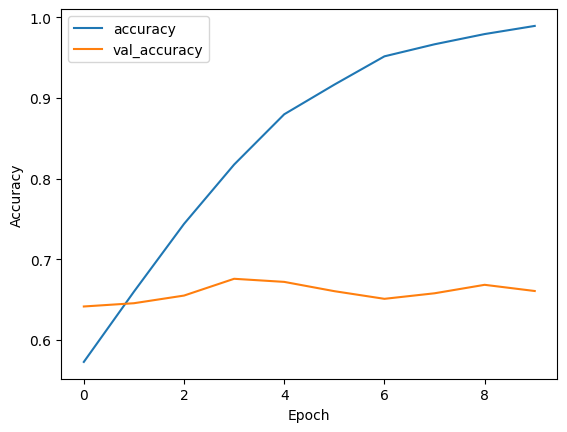

In [11]:
model = Sequential(
    [
        Rescaling(1./255, input_shape=(224, 224, 3)),
        Conv2D(filters=9, kernel_size=(5,5), activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

Podem veure com solament amb una capa convolucional i una capa densa el resultat ja es prou millor que amb la xarxa feed forward. Es obvi com ja es comencen a identificar patrons que identifiquen a gossos i gats, encara que en trobat amb _overfitting_: a partir de la tercera época el `loss` baixa de forma decidida pero el `val_loss` comença a pujar. Per altra banda l'`accuracy` puja i el `val_accuracy` es queda estancat.

Això és degut a que la xarxa és molt petita. Haurem d'apilar més capes convolucionals i de _pooling_ per a millorar el rendiment.

La primera capa convolucional capta patrons bàsics com línies i corbes. Si agreguem més capes convolucionals, aquestes podran capturar patrons més complexos com formes `bàsiques` i, finalment, l'objecte que volem classificar. També augmentarem el nombre de `filters` conforme anem afegint capes convolucionals, ja que conforme els patrons es compliquen hi haurà més possible combinacions de característiques interessants que caldrà capturar.

Per facilitar aquest procés, utilitzarem una tècnica molt útil: reduir el tamany espacial de les imatges. Si hem detectat que en una finestra de `3x3` hi ha una característica important, no ens importa si aquesta característica està en la part superior o inferior de la imatge. Així que podem reduir la mida de la imatge a la meitat. Això és el que fa la capa de _pooling_.

Hi ha dos tipus de _pooling_: _max pooling_ i _average pooling_. El _max pooling_ agafa el valor màxim de la finestra i l'_average pooling_ en fa la mitjana. En general, el _max pooling_ funciona millor que l'_average pooling_.

L'estructura bàsica serà la de capa convolucional, capa de _pooling_ i capa de _dropout_. La capa de _dropout_ és molt útil per a reduir l'overfitting.

Vejam com es comporta la xarxa amb aquesta nova estructura.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 10)      760       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 10)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 10)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 20)      5020      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 20)        0         
 g2D)                                                 

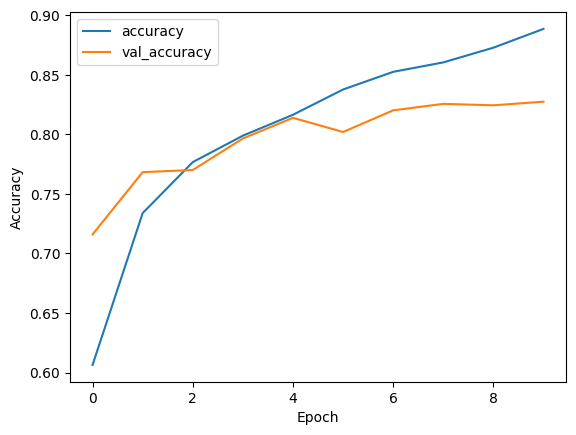

In [12]:
model = Sequential(
    [
        Rescaling(1./255, input_shape=(224, 224, 3)),
        Conv2D(filters=10, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=20, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=40, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

Com podem veure, el rendiment de la xarxa ha millorat prou. Encara hi ha molt marge de millora, ara, però, no tenim un overfitting destacable i seria possible seguir afegint capes convolucionals i de _pooling_ per a millorar el rendiment.

De tota manera anem a veure una altra técnica: _data augmentation_ aplicarem una série de filtres a les imatges (escalats i rotacions) per dversificar les dades d'entrada i, per tant ajudar a la xarxa a generalitzar-se.

Ho podeu executar per veure el resultat. Es possible, però, que necessite més de 10 époques per convergir.

In [ ]:
from keras_cv.layers import RandAugment

model = Sequential(
    [
        Rescaling(1./255, input_shape=(224, 224, 3)),
        RandAugment(value_range=(0, 255), augmentations_per_image=1, magnitude=0.5),
        Conv2D(filters=10, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=20, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(filters=40, kernel_size=(5,5), activation='relu', padding='same'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

## Xarxes neuronals convolucionals (CNN) pre-entrenades

Com haurem vist, entrenar una xarxa neuronal convolucional des de zero és una tasca molt costosa. Això és degut a que les xarxes neuronals convolucionals tenen molts paràmetres i entrenar-les requereix moltes dades i temps.

Afortunadament, podem utilitzar xarxes neuronals convolucionals pre-entrenades. Això ens estalvia molt temps i recursos.

Veurem com afinar una xarxa neuronal convolucional pre-entrenada per a que classifique les nostres dades.



Com a exemple, utilitzarem la xarxa `VGG16` pre-entrenada. La xarxa `VGG16` és una xarxa neuronal convolucional molt coneguda i ha estat entrenada amb el conjunt de dades `ImageNet`, que conté més de 14 milions d'imatges i 1000 classes diferents. Està formada per 16 capes, d'aquí el nom. La xarxa `VGG16` és molt potent i ha demostrat ser molt eficient en tasques de classificació d'imatges.

In [ ]:
from keras.applications import VGG16

model = Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)),
    VGG16(include_top=False),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.layers[1].trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(ds_train, epochs=10, batch_size=128, validation_data=ds_test)

plot_history(history)

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               3211392   
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 17927370 (68.39 MB)
Trainable params: 3212682 (12.26 MB)
Non-trainable params: 14714688 (56.13 MB)
________

El resultat ara és molt millor. Això és degut a que hem pogut utilitzar les característiques apreses per la xarxa pre-entrenada per a classificar les imatges.

El _transfer learning_ és molt útil quan no tenim moltes dades o quan no tenim molts recursos per a entrenar una xarxa neuronal convolucional des de zero.

## Utilització en OpenCV

Per a utilitzar la xarxa neuronal convolucional pre-entrenada en OpenCV hauriem de convertir la xarxa a un format que OpenCV pugui llegir. Això és una mica complicat, però es pot fer. De tota manera en aquesta secció veurem com cridar al model de Keras des de OpenCV.

In [51]:
# En opencv carreguem una imatge, la classifiquem i la mostrem.

import cv2

def classify_image_opencv(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) # Carreguem la imatge amb opencv i la convertim a RGB

    img_class = img # Creem una còpia de la imatge per modificar-la
    img_class = cv2.resize(img_class, (224, 224)) # Redimensionem la imatge a 224x224
    img_class = np.expand_dims(img_class, axis=0) # Redimensionem la imatge afegint una dimensió extra per indicar el batch

    pred = model.predict(img_class) # Classifiquem la imatge amb el model

    # Modifiquem la imatge original per agregar la etiqueta en verd
    if pred[0][0] > 0.5:
        print("Cat")
        cv2.putText(img, "Cat", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        print("Dog")
        cv2.putText(img, "Dog", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    plt.imshow(img)

1/1 [==============================] - 0s 19ms/step
Cat


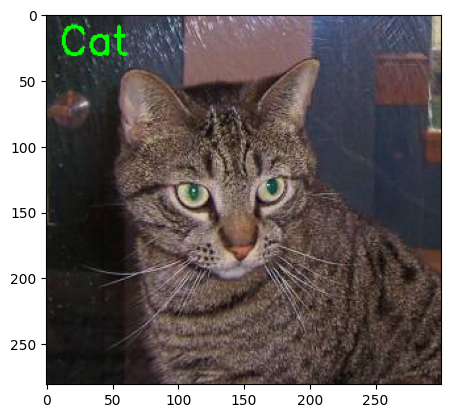

In [52]:
classify_image_opencv('data/PetImages/Cat/1.jpg')

1/1 [==============================] - 0s 20ms/step
Dog


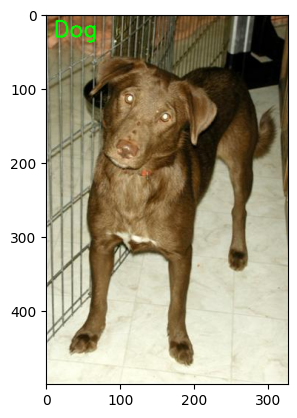

In [53]:
classify_image_opencv('data/PetImages/Dog/1.jpg')